In [1]:
import os, io, zipfile, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

DATA_ZIP = Path("C:\\Users\\ik_ad\\Downloads\\city_bike_NYC.zip")  # adjust if needed
OUT_DIR = Path("./citibike_outputs"); OUT_DIR.mkdir(exist_ok=True, parents=True)

print("Zip present:", DATA_ZIP.exists(), "-> outputs:", OUT_DIR)

Zip present: True -> outputs: citibike_outputs


In [2]:
# Harmonize Citibike-like CSV columns across months/years
COMMON_COLS = {
    'starttime': ['starttime','start_time','started_at','start_time_local'],
    'stoptime':  ['stoptime','stop_time','ended_at','end_time_local'],
    'start station id': ['start station id','start_station_id','start station id '],
    'start station name': ['start station name','start_station_name'],
    'start station latitude': ['start station latitude','start_latitude','startlat','start station lat','start_lat'],
    'start station longitude': ['start station longitude','start_longitude','startlon','start station lon','start_lng'],
    'end station id': ['end station id','end_station_id','end station id '],
    'end station name': ['end station name','end_station_name'],
    'end station latitude': ['end station latitude','end_latitude','endlat','end station lat','end_lat'],
    'end station longitude': ['end station longitude','end_longitude','endlon','end station lon','end_lng'],
}

def harmonize_columns(df):
    out = {}
    for std, aliases in COMMON_COLS.items():
        for a in aliases:
            if a in df.columns:
                out[std] = df[a]
                break
    return pd.DataFrame(out)

dfs = []
with zipfile.ZipFile(DATA_ZIP, "r") as z:
    names = [n for n in z.namelist() if n.lower().endswith(".csv")]
    print(f"Found {len(names)} CSVs")
    for n in names:
        with z.open(n) as f:
            try:
                tmp = pd.read_csv(f, low_memory=False)
            except Exception:
                f.seek(0)
                tmp = pd.read_csv(f, encoding="latin1", low_memory=False)
        h = harmonize_columns(tmp)
        h = h.dropna(subset=[
            "start station latitude","start station longitude",
            "end station latitude","end station longitude"
        ])
        dfs.append(h)

trips = pd.concat(dfs, ignore_index=True)
print("Trips loaded:", len(trips))
trips.head(3)

Found 2 CSVs
Trips loaded: 1953829


,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude
0,2024-01-15 18:13:13,2024-01-15 18:17:09,5669.1,St Marks Pl & 2 Ave,40.728419,-73.987140,5626.15,1 Ave & E 6 St,40.726331,-73.986169
1,2024-01-23 18:00:07,2024-01-23 18:02:11,5669.1,St Marks Pl & 2 Ave,40.728374,-73.986988,5626.15,1 Ave & E 6 St,40.726331,-73.986169
2,2024-01-23 09:44:05,2024-01-23 09:47:23,5669.1,St Marks Pl & 2 Ave,40.728279,-73.987133,5515.08,E 4 St & Ave B,40.723347,-73.982659


In [3]:
trip_feats = trips[[
    "start station latitude","end station latitude",
    "start station longitude","end station longitude"
]].copy()
trip_feats.columns = ["s_lat","e_lat","s_lng","e_lng"]

# Sample for k selection (speeds up elbow/silhouette); increase if you can
SAMPLE_TRIPS = 50_000
trip_sample = (trip_feats.sample(n=SAMPLE_TRIPS, random_state=42)
               if len(trip_feats) > SAMPLE_TRIPS else trip_feats.copy())

print("Trip feature shapes:", trip_feats.shape, "(full) /", trip_sample.shape, "(sample)")
trip_feats.head(3)

Trip feature shapes: (1953829, 4) (full) / (50000, 4) (sample)


,s_lat,e_lat,s_lng,e_lng
0,40.728419,40.726331,-73.987140,-73.986169
1,40.728374,40.726331,-73.986988,-73.986169
2,40.728279,40.723347,-73.987133,-73.982659


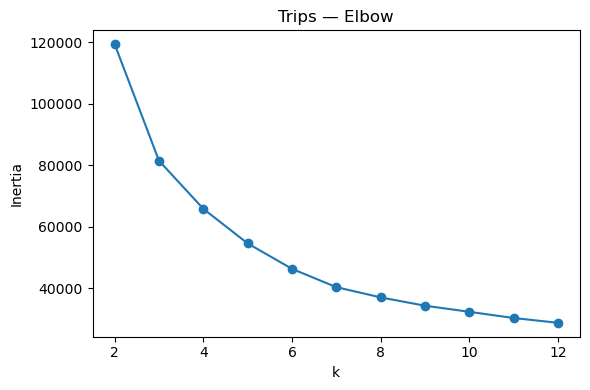

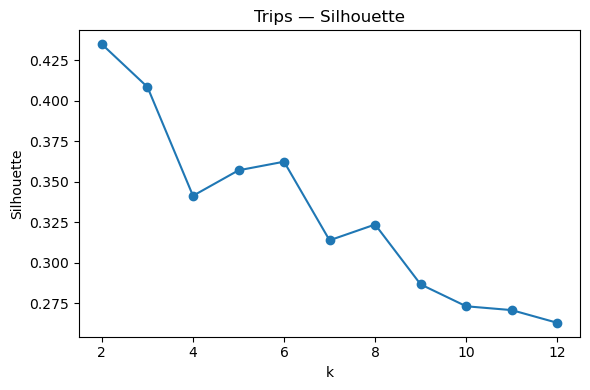

Chosen k for trips: 2 (silhouette peak at 2 )


In [4]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def choose_k(X, ks=range(2,13)):
    inertias, sils = [], []
    for k in ks:
        km = KMeans(n_clusters=k, init="random", n_init=10, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_)
        labels = km.labels_
        sil = silhouette_score(X, labels) if len(np.unique(labels))>1 else np.nan
        sils.append(sil)
    return inertias, sils

scaler = StandardScaler()
Xs = scaler.fit_transform(trip_sample.values)

ks = list(range(2,13))
inertias, sils = choose_k(Xs, ks)

plt.figure(figsize=(6,4)); plt.plot(ks, inertias, marker="o")
plt.title("Trips — Elbow"); plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(ks, sils, marker="o")
plt.title("Trips — Silhouette"); plt.xlabel("k"); plt.ylabel("Silhouette")
plt.tight_layout(); plt.show()

best_k_sil = ks[int(np.nanargmax(sils))]
# Simple elbow pick: the smallest k within ~5–10% of the largest inertia drop
d = np.diff(inertias)
elbow_k = best_k_sil
for i in range(1,len(d)):
    if d[i] > 0 and d[i] / (abs(d[i-1])+1e-9) < 0.1:
        elbow_k = ks[i]
        break

K_TRIPS = elbow_k
print("Chosen k for trips:", K_TRIPS, "(silhouette peak at", best_k_sil, ")")

In [ ]:
X_full = StandardScaler().fit_transform(trip_feats.values)

km_random = KMeans(n_clusters=K_TRIPS, init="random", n_init=20, random_state=42).fit(X_full)
km_plus   = KMeans(n_clusters=K_TRIPS, init="k-means++", n_init=20, random_state=42).fit(X_full)

labels_random, labels_plus = km_random.labels_, km_plus.labels_
sil_rand = silhouette_score(X_full, labels_random) if len(np.unique(labels_random))>1 else np.nan
sil_plus = silhouette_score(X_full, labels_plus) if len(np.unique(labels_plus))>1 else np.nan

trip_summary = pd.DataFrame({
    "algorithm": ["k-means (random)","k-means++"],
    "k": [K_TRIPS, K_TRIPS],
    "inertia": [km_random.inertia_, km_plus.inertia_],
    "silhouette": [sil_rand, sil_plus]
})
trip_summary


In [ ]:
def destandardize_centers(km, ref_df):
    scaler = StandardScaler().fit(ref_df.values)
    centers = scaler.inverse_transform(km.cluster_centers_)
    return pd.DataFrame(centers, columns=ref_df.columns)

centers_rand = destandardize_centers(km_random, trip_feats)
centers_plus = destandardize_centers(km_plus, trip_feats)

def plot_trip_centers(C, title):
    plt.figure(figsize=(6,5))
    plt.scatter(C["s_lng"], C["s_lat"], s=60, marker="o", alpha=0.9, label="start")
    plt.scatter(C["e_lng"], C["e_lat"], s=60, marker="^", alpha=0.9, label="end")
    for _, r in C.iterrows():
        plt.plot([r["s_lng"], r["e_lng"]], [r["s_lat"], r["e_lat"]], alpha=0.5)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.legend(); plt.title(title); plt.tight_layout(); plt.show()

plot_trip_centers(centers_rand, f"Trips — centers (k-means, k={K_TRIPS})")
plot_trip_centers(centers_plus, f"Trips — centers (k-means++, k={K_TRIPS})")


In [ ]:
def to_datetime_any(x):
    try:
        return pd.to_datetime(x, errors="coerce")
    except Exception:
        return pd.NaT

st = trips["starttime"].apply(to_datetime_any)
et = trips["stoptime"].apply(to_datetime_any)
trips["_shour"] = pd.to_datetime(st).dt.hour
trips["_ehour"] = pd.to_datetime(et).dt.hour

# Hourly to/from counts
start_counts = (trips.groupby(["start station id","_shour"]).size()
                .unstack(fill_value=0).reindex(columns=range(24), fill_value=0))
end_counts   = (trips.groupby(["end station id","_ehour"]).size()
                .unstack(fill_value=0).reindex(columns=range(24), fill_value=0))

start_counts.index.name = end_counts.index.name = "sid"
station_hourly = start_counts.add(end_counts, fill_value=0).astype(int)
print("Stations x 24:", station_hourly.shape)


In [ ]:
SAMPLE_STATIONS = 2000
station_sample = (station_hourly.sample(n=SAMPLE_STATIONS, random_state=42)
                  if len(station_hourly) > SAMPLE_STATIONS else station_hourly)

Xs = StandardScaler().fit_transform(station_sample.values.astype(float))
ks = list(range(2,13))
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, init="random", n_init=10, random_state=42).fit(Xs)
    inertias.append(km.inertia_)
    labels = km.labels_
    sils.append(silhouette_score(Xs, labels) if len(np.unique(labels))>1 else np.nan)

plt.figure(figsize=(6,4)); plt.plot(ks, inertias, marker="o")
plt.title("Stations — Elbow"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(ks, sils, marker="o")
plt.title("Stations — Silhouette"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.tight_layout(); plt.show()

K_STATIONS = ks[int(np.nanargmax(sils))]  # silhouette peak works well here
print("Chosen k for stations:", K_STATIONS)


In [ ]:
X_stat = StandardScaler().fit_transform(station_hourly.values.astype(float))
km_s_rand = KMeans(n_clusters=K_STATIONS, init="random", n_init=20, random_state=42).fit(X_stat)
km_s_plus = KMeans(n_clusters=K_STATIONS, init="k-means++", n_init=20, random_state=42).fit(X_stat)

lab_s_rand, lab_s_plus = km_s_rand.labels_, km_s_plus.labels_
sil_s_rand = silhouette_score(X_stat, lab_s_rand) if len(np.unique(lab_s_rand))>1 else np.nan
sil_s_plus = silhouette_score(X_stat, lab_s_plus) if len(np.unique(lab_s_plus))>1 else np.nan

station_summary = pd.DataFrame({
    "algorithm": ["k-means (random)","k-means++"],
    "k": [K_STATIONS, K_STATIONS],
    "inertia": [km_s_rand.inertia_, km_s_plus.inertia_],
    "silhouette": [sil_s_rand, sil_s_plus]
})
station_summary


In [ ]:
def plot_avg_profiles(labels, title):
    df = station_hourly.copy()
    df["cluster"] = labels
    avg = df.groupby("cluster").mean().iloc[:, :24]
    plt.figure(figsize=(7,5))
    for cid, row in avg.iterrows():
        plt.plot(range(24), row.values, label=f"C{cid}")
    plt.xlabel("Hour"); plt.ylabel("Avg trips (to+from)")
    plt.legend(ncol=2, fontsize=8); plt.title(title)
    plt.tight_layout(); plt.show()
    return avg

avg_rand = plot_avg_profiles(lab_s_rand, f"Stations — avg profiles (k-means, k={K_STATIONS})")
avg_plus = plot_avg_profiles(lab_s_plus, f"Stations — avg profiles (k-means++, k={K_STATIONS})")
